In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from os.path import join
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(256000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((76

See this issue, the official loading code will fail, use this instead https://huggingface.co/google/siglip2-base-patch16-224/discussions/2

In [17]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch >= 2.31.0, timm >= 1.0.15

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP2')
# tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP2')
image = Image.open(urlopen(
    'https://github.com/NVlabs/RADIO/raw/main/assets/radio.png'
))
image = preprocess(image).unsqueeze(0)
# labels_list = ["a dog", "a cat", "a donut", "a beignet"]
# text = tokenizer(labels_list, context_length=model.context_length)
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image, normalize=True)
    # text_features = model.encode_text(text, normalize=True)
    # text_probs = torch.sigmoid(image_features @ text_features.T * model.logit_scale.exp() + model.logit_bias)
# zipped_list = list(zip(labels_list, [100 * round(p.item(), 3) for p in text_probs[0]]))
# print("Label probabilities: ", zipped_list)

In [19]:
preprocess

Compose(
    Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
    <function _convert_to_rgb at 0x14c039e368c0>
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [7]:
# from transformers.models.siglip.modeling_siglip import SiglipModel
# import torch
# from transformers import AutoModel, AutoProcessor, AutoImageProcessor
# from transformers.image_utils import load_image

# # load the model and processor
# ckpt = "google/siglip2-base-patch16-224"
# model = AutoModel.from_pretrained(ckpt, device_map="auto").eval()
# processor = AutoImageProcessor.from_pretrained(ckpt)

# # load the image
# image = load_image("https://huggingface.co/datasets/merve/coco/resolve/main/val2017/000000000285.jpg")
# inputs = processor(images=[image], return_tensors="pt").to(model.device)

# # run infernece
# with torch.no_grad():
#     image_embeddings = model.get_image_features(**inputs)    

# print(image_embeddings.shape)

torch.Size([1, 768])


### Fetch features and understand feature structure

### Fit encoding models for vision transformer

In [20]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

In [21]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

In [23]:
stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
# datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir = join(stimuli_root, "stimuli_pilot_20241119/results")
# imgdir_day3 = join(stimuli_root, "results_12-01-2025")
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

subjects: ['red_20241212-20241220']


In [24]:
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [imgdir_shared, imgdir])
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, subject_id, "model_outputs")
os.makedirs(figdir, exist_ok=True)

All stimulus files were found


In [25]:
from torchvision import transforms as T
from circuit_toolkit.layer_hook_utils import featureFetcher, recursive_print

In [27]:
recursive_print(model, deepest=4)

[CustomTextCLIP]
(visual): TimmModel
  (trunk): VisionTransformer
    (patch_embed): PatchEmbed
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential
      (0): Block
      (1): Block
      (2): Block
      (3): Block
      (4): Block
      (5): Block
      (6): Block
      (7): Block
      (8): Block
      (9): Block
      (10): Block
      (11): Block
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn_pool): AttentionPoolLatent
      (q): Linear(in_features=768, out_features=768, bias=True)
      (kv): Linear(in_features=768, out_features=1536, bias=True)
      (q_norm): Identity()
      (k_norm): Identity()
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
      (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (

In [32]:
fetcher = featureFetcher(model.visual, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values()   if ".trunk.blocks.Block" in name]

In [33]:
module_names

['.trunk.blocks.Block0',
 '.trunk.blocks.Block1',
 '.trunk.blocks.Block2',
 '.trunk.blocks.Block3',
 '.trunk.blocks.Block4',
 '.trunk.blocks.Block5',
 '.trunk.blocks.Block6',
 '.trunk.blocks.Block7',
 '.trunk.blocks.Block8',
 '.trunk.blocks.Block9',
 '.trunk.blocks.Block10',
 '.trunk.blocks.Block11']

In [54]:
module_names = [name for name in fetcher.module_names.values()  ]
module_names

['Image',
 '.trunk.patch_embed.Conv2dproj',
 '.trunk.patch_embed.Identitynorm',
 '.trunk.PatchEmbedpatch_embed',
 '.trunk.Dropoutpos_drop',
 '.trunk.Identitypatch_drop',
 '.trunk.Identitynorm_pre',
 '.trunk.blocks.0.LayerNormnorm1',
 '.trunk.blocks.0.attn.Linearqkv',
 '.trunk.blocks.0.attn.Identityq_norm',
 '.trunk.blocks.0.attn.Identityk_norm',
 '.trunk.blocks.0.attn.Linearproj',
 '.trunk.blocks.0.attn.Dropoutproj_drop',
 '.trunk.blocks.0.Attentionattn',
 '.trunk.blocks.0.Identityls1',
 '.trunk.blocks.0.Identitydrop_path1',
 '.trunk.blocks.0.LayerNormnorm2',
 '.trunk.blocks.0.mlp.Linearfc1',
 '.trunk.blocks.0.mlp.GELUact',
 '.trunk.blocks.0.mlp.Dropoutdrop1',
 '.trunk.blocks.0.mlp.Identitynorm',
 '.trunk.blocks.0.mlp.Linearfc2',
 '.trunk.blocks.0.mlp.Dropoutdrop2',
 '.trunk.blocks.0.Mlpmlp',
 '.trunk.blocks.0.Identityls2',
 '.trunk.blocks.0.Identitydrop_path2',
 '.trunk.blocks.Block0',
 '.trunk.blocks.1.LayerNormnorm1',
 '.trunk.blocks.1.attn.Linearqkv',
 '.trunk.blocks.1.attn.Identit

In [ ]:
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch >= 2.31.0, timm >= 1.0.15
model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP2')
# tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP2')
# image = Image.open(urlopen(
#     'https://github.com/NVlabs/RADIO/raw/main/assets/radio.png'
# ))
# image = preprocess(image).unsqueeze(0)
# labels_list = ["a dog", "a cat", "a donut", "a beignet"]
# text = tokenizer(labels_list, context_length=model.context_length)
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image, normalize=True)

In [34]:
type(model)
# https://github.com/mlfoundations/open_clip/blob/bf5d49c112c82c738f7b34bde6e154760a711790/src/open_clip/model.py#L487

open_clip.model.CustomTextCLIP

In [55]:
batch_size = 96
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
modelname = "ViT-B-16-SigLIP2"  
resolution = (224, 224)
siglip_model, transforms_pipeline = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP2')
model = siglip_model.visual.eval().to(device)
model.requires_grad_(False)
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values()   if ".trunk.blocks.Block" in name or ".trunk.AttentionPoolLatentattn_pool" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# # Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

.trunk.blocks.Block0 torch.Size([1028, 196, 768])
.trunk.blocks.Block1 torch.Size([1028, 196, 768])
.trunk.blocks.Block2 torch.Size([1028, 196, 768])
.trunk.blocks.Block3 torch.Size([1028, 196, 768])
.trunk.blocks.Block4 torch.Size([1028, 196, 768])
.trunk.blocks.Block5 torch.Size([1028, 196, 768])
.trunk.blocks.Block6 torch.Size([1028, 196, 768])
.trunk.blocks.Block7 torch.Size([1028, 196, 768])
.trunk.blocks.Block8 torch.Size([1028, 196, 768])
.trunk.blocks.Block9 torch.Size([1028, 196, 768])
.trunk.blocks.Block10 torch.Size([1028, 196, 768])
.trunk.blocks.Block11 torch.Size([1028, 196, 768])
.trunk.AttentionPoolLatentattn_pool torch.Size([1028, 768])
FeatureFetcher hooks all freed


### Attention Pooling mechanism of SIGLIP

In [46]:
import inspect
print(inspect.getsource(model.trunk.forward))
print(inspect.getsource(model.trunk.forward_features))
print(inspect.getsource(model.trunk.forward_head))
print(inspect.getsource(model.trunk.pool))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        x = self._pos_embed(x)
        x = self.patch_drop(x)
        x = self.norm_pre(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            x = self.blocks(x)
        x = self.norm(x)
        return x

    def forward_head(self, x: torch.Tensor, pre_logits: bool = False) -> torch.Tensor:
        x = self.pool(x)
        x = self.fc_norm(x)
        x = self.head_drop(x)
        return x if pre_logits else self.head(x)

    def pool(self, x: torch.Tensor, pool_type: Optional[str] = None) -> torch.Tensor:
        if self.attn_pool is not None:
            x = self.attn_pool(x)
            return x
        pool_type = self.global_pool if pool_type is None else p

In [49]:
model.trunk.attn_pool

AttentionPoolLatent(
  (q): Linear(in_features=768, out_features=768, bias=True)
  (kv): Linear(in_features=768, out_features=1536, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
)

In [48]:
print(inspect.getsource(model.trunk.attn_pool.forward))

    def forward(self, x):
        B, N, C = x.shape

        if self.pos_embed is not None:
            # FIXME interpolate
            x = x + self.pos_embed.unsqueeze(0).to(x.dtype)

        q_latent = self.latent.expand(B, -1, -1)
        q = self.q(q_latent).reshape(B, self.latent_len, self.num_heads, self.head_dim).transpose(1, 2)

        kv = self.kv(x).reshape(B, N, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        k, v = kv.unbind(0)

        q, k = self.q_norm(q), self.k_norm(k)

        if self.fused_attn:
            x = F.scaled_dot_product_attention(q, k, v)
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)
            attn = attn.softmax(dim=-1)
            x = attn @ v
        x = x.transpose(1, 2).reshape(B, self.latent_len, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        x = x + self.mlp(self.norm(x))

        # optional pool if latent seq_len > 1 and pooled output is desired
        if self.pool 

### Neural Regression and prediction

In [56]:
import time
from neural_regress.regress_lib import transform_features2Xdict, sweep_regressors, MultiTaskLassoCV, MultiOutputSeparateLassoCV, RidgeCV

In [59]:
def get_maxpool_space_token(X):
    return X[:, :, :].max(dim=1)[0]


def get_avgpool_space_token(X):
    return X[:, :, :].mean(dim=1)

In [57]:
Xtransforms_dict = {
    "maxpool_space_token": get_maxpool_space_token,
    "avgpool_space_token": get_avgpool_space_token,
    "full": lambda X: X,
}

NameError: name 'get_maxpool_space_token' is not defined

In [62]:
import torch
import torch.nn as nn

class SummaryFlatten(nn.Module):
    def __init__(self, summary_idxs: torch.LongTensor):
        super().__init__()
        # register_idxs as a buffer so it moves with .to(device), .eval(), etc.
        self.register_buffer('summary_idxs', summary_idxs)

    def forward(self, X: torch.Tensor):
        # X: (B, T, C)
        return X[:, self.summary_idxs, :].flatten(1)


class ExtraClsFlatten(nn.Module):
    def __init__(self, max_summary_idx: int, num_cls_tokens: int):
        super().__init__()
        self.max_summary_idx = max_summary_idx
        self.num_cls_tokens = num_cls_tokens

    def forward(self, X: torch.Tensor):
        return X[:, self.max_summary_idx : self.num_cls_tokens, :].flatten(1)


class ClsWithoutSummaryFlatten(nn.Module):
    def __init__(self, max_summary_idx: int, num_skip: int):
        super().__init__()
        self.max_summary_idx = max_summary_idx
        self.num_skip = num_skip

    def forward(self, X: torch.Tensor):
        return X[:, self.max_summary_idx : self.num_skip, :].flatten(1)


class MaxPoolSpaceToken(nn.Module):
    def __init__(self, num_skip: int):
        super().__init__()
        self.num_skip = num_skip

    def forward(self, X: torch.Tensor):
        # returns (B, C)
        return X[:, self.num_skip:, :].max(dim=1)[0]


class AvgPoolSpaceToken(nn.Module):
    def __init__(self, num_skip: int):
        super().__init__()
        self.num_skip = num_skip

    def forward(self, X: torch.Tensor):
        # returns (B, C)
        return X[:, self.num_skip:, :].mean(dim=1)

In [63]:
Xtransforms_dict = {
    "maxpool_space_token": MaxPoolSpaceToken(0),
    "avgpool_space_token": AvgPoolSpaceToken(0),
    "full": nn.Identity(),
}

In [64]:
module_names

['.trunk.blocks.Block0',
 '.trunk.blocks.Block1',
 '.trunk.blocks.Block2',
 '.trunk.blocks.Block3',
 '.trunk.blocks.Block4',
 '.trunk.blocks.Block5',
 '.trunk.blocks.Block6',
 '.trunk.blocks.Block7',
 '.trunk.blocks.Block8',
 '.trunk.blocks.Block9',
 '.trunk.blocks.Block10',
 '.trunk.blocks.Block11',
 '.trunk.AttentionPoolLatentattn_pool']

In [65]:
Xdict_lyrswp = {}
Xtfmer_lyrswp = {}
for layer in module_names:
    for dimred_str, transform_func in Xtransforms_dict.items():
        # Implement XOR case: skip if attn_pool is in layer OR if full is in dimred_str, but not both
        if ("attn_pool" in layer) != ("full" in dimred_str):
            continue
        t0 = time.time()
        Xdict_lyrswp[f"{layer}_{dimred_str}"] = transform_func(feat_dict_lyrswp[layer])
        Xtfmer_lyrswp[f"{layer}_{dimred_str}"] = transform_func
        print(f"Time taken to transform {layer} x {dimred_str}: {time.time() - t0:.3f}s")

Time taken to transform .trunk.blocks.Block0 x maxpool_space_token: 0.259s
Time taken to transform .trunk.blocks.Block0 x avgpool_space_token: 0.059s
Time taken to transform .trunk.blocks.Block1 x maxpool_space_token: 0.252s
Time taken to transform .trunk.blocks.Block1 x avgpool_space_token: 0.058s
Time taken to transform .trunk.blocks.Block2 x maxpool_space_token: 0.258s
Time taken to transform .trunk.blocks.Block2 x avgpool_space_token: 0.058s
Time taken to transform .trunk.blocks.Block3 x maxpool_space_token: 0.247s
Time taken to transform .trunk.blocks.Block3 x avgpool_space_token: 0.058s
Time taken to transform .trunk.blocks.Block4 x maxpool_space_token: 0.249s
Time taken to transform .trunk.blocks.Block4 x avgpool_space_token: 0.058s
Time taken to transform .trunk.blocks.Block5 x maxpool_space_token: 0.244s
Time taken to transform .trunk.blocks.Block5 x avgpool_space_token: 0.058s
Time taken to transform .trunk.blocks.Block6 x maxpool_space_token: 0.246s
Time taken to transform .

In [66]:
resp_mat_sel = resp_mat
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
#                                                         pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

.trunk.blocks.Block0_maxpool_space_token RidgeCV D2_train: 0.270 D2_test: 0.068 time: 0.257
.trunk.blocks.Block0_avgpool_space_token RidgeCV D2_train: 0.185 D2_test: 0.088 time: 0.245
.trunk.blocks.Block1_maxpool_space_token RidgeCV D2_train: 0.189 D2_test: 0.059 time: 0.247
.trunk.blocks.Block1_avgpool_space_token RidgeCV D2_train: 0.304 D2_test: 0.159 time: 0.243
.trunk.blocks.Block2_maxpool_space_token RidgeCV D2_train: 0.395 D2_test: 0.142 time: 0.248
.trunk.blocks.Block2_avgpool_space_token RidgeCV D2_train: 0.441 D2_test: 0.310 time: 0.247
.trunk.blocks.Block3_maxpool_space_token RidgeCV D2_train: 0.425 D2_test: 0.246 time: 0.246
.trunk.blocks.Block3_avgpool_space_token RidgeCV D2_train: 0.531 D2_test: 0.388 time: 0.245
.trunk.blocks.Block4_maxpool_space_token RidgeCV D2_train: 0.534 D2_test: 0.323 time: 0.249
.trunk.blocks.Block4_avgpool_space_token RidgeCV D2_train: 0.552 D2_test: 0.412 time: 0.249
.trunk.blocks.Block5_maxpool_space_token RidgeCV D2_train: 0.500 D2_test: 0.339 

In [67]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [69]:
result_df_lyrswp

,,alpha,train_score,test_score,n_feat,runtime
.trunk.blocks.Block0_maxpool_space_token,RidgeCV,"[100.0, 100.0, 100.0, 1000.0, 100.0, 100.0, 10...",0.269705,0.067669,768,0.257385
.trunk.blocks.Block0_avgpool_space_token,RidgeCV,"[1.0, 10.0, 10.0, 100.0, 1.0, 10.0, 10.0, 10.0...",0.18471,0.088387,768,0.244807
.trunk.blocks.Block1_maxpool_space_token,RidgeCV,"[100.0, 100.0, 100.0, 1000.0, 100.0, 100.0, 10...",0.189447,0.058781,768,0.246642
.trunk.blocks.Block1_avgpool_space_token,RidgeCV,"[1.0, 1.0, 1.0, 100.0, 1.0, 10.0, 1.0, 1.0, 1....",0.303689,0.159392,768,0.243351
.trunk.blocks.Block2_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 100.0, 10.0, 1...",0.394907,0.141507,768,0.247765
.trunk.blocks.Block2_avgpool_space_token,RidgeCV,"[1.0, 1.0, 1.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.440554,0.310045,768,0.247022
.trunk.blocks.Block3_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 100.0, 10.0, 1...",0.424703,0.246107,768,0.246423
.trunk.blocks.Block3_avgpool_space_token,RidgeCV,"[1.0, 1.0, 1.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.530551,0.388196,768,0.245461
.trunk.blocks.Block4_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 100.0, 10.0, 1...",0.533953,0.322922,768,0.248784
.trunk.blocks.Block4_avgpool_space_token,RidgeCV,"[1.0, 1.0, 1.0, 10.0, 1.0, 10.0, 1.0, 1.0, 1.0...",0.551729,0.411923,768,0.249177


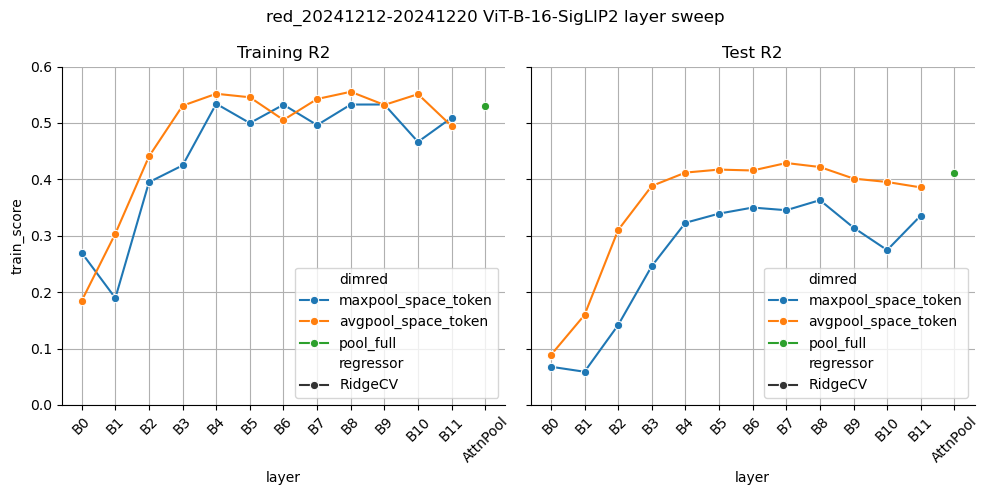

In [77]:
layer_shorten_func = lambda x: x.replace(".trunk.blocks.Block", "B").replace(".trunk.AttentionPoolLatentattn", "AttnPool")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True, ylim=(0, 0.6))
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

In [78]:
layer_shorten_func = lambda x: x.replace(".trunk.blocks.Block", "B").replace(".trunk.AttentionPoolLatentattn", "AttnPool")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True, ylim=(0, None))
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    result_df_masked_formatted = format_result_df(result_df_masked, dimred_list=list(Xtransforms_dict))
    figh = plot_result_df_per_layer(result_df_masked_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True, ylim=(0, None))
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")

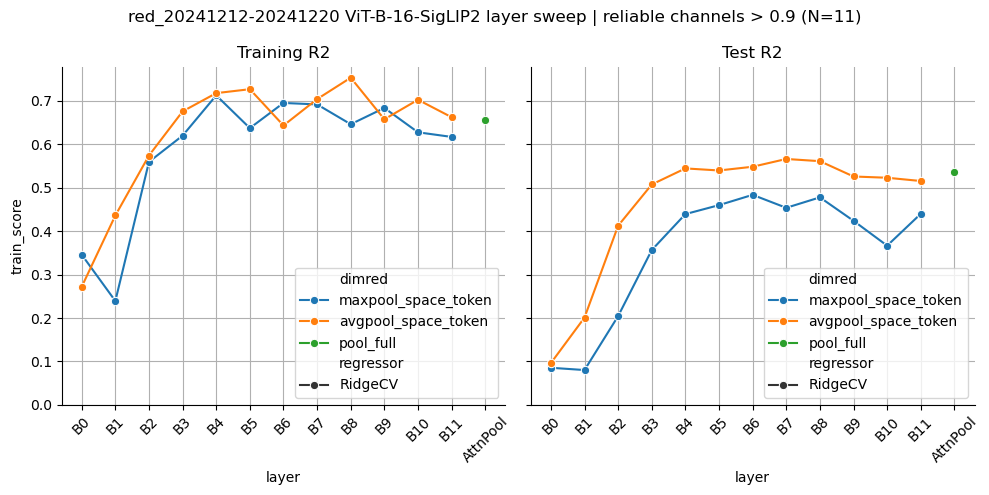

In [79]:
figh

### Export the models

In [80]:
from neural_regress.sklearn_torchify_lib import LinearLayer_from_sklearn
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"

In [81]:
list(fit_models_lyrswp.keys())

[('.trunk.blocks.Block0_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block0_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block1_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block1_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block2_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block2_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block3_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block3_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block4_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block4_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block5_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block5_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block6_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block6_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block7_maxpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block7_avgpool_space_token', 'RidgeCV'),
 ('.trunk.blocks.Block8_maxpool_space_token', 'RidgeCV'),
 ('.trunk.bloc

In [82]:
modelname

'ViT-B-16-SigLIP2'

In [83]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs'

In [91]:
# save resp statistics 
mean_resp = resp_mat.mean(0)
std_resp = resp_mat.std(0)
q05_resp = np.percentile(resp_mat, 5, axis=0)
q95_resp = np.percentile(resp_mat, 95, axis=0)
min_resp = resp_mat.min(0)
max_resp = resp_mat.max(0)
resp_stats = {
    "resp_mat": resp_mat,
    "mean_resp": mean_resp,
    "std_resp": std_resp,
    "q05_resp": q05_resp,
    "q95_resp": q95_resp,
    "min_resp": min_resp,
    "max_resp": max_resp,
}
np.savez(join(figdir, f"{subject_id}_resp_stats.npz"), **resp_stats)

In [92]:
# modelname = 'ViT-B-16-SigLIP2'
keys2export = [ 
               ('.trunk.blocks.Block7_avgpool_space_token', 'RidgeCV'),
            ]
# for modelname in ["dinov2_vitb14_reg"]:
Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth")
readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
fit_models_lyrswp_RidgeCV = th.load(readout_path)
Xtfmer_lyrswp_RidgeCV = th.load(Xtransform_path)
pred_data = pkl.load(open(meta_path, "rb"))
for key in keys2export:
    export_readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
    export_Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pth")
    export_meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

    regressor = fit_models_lyrswp_RidgeCV[key]
    Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
    pred_rsp = pred_data["pred_dict"][key]
    D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
    D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]
    readout = LinearLayer_from_sklearn(regressor)
    th.save(readout, export_readout_path)
    th.save(Xtfmer, export_Xtransform_path)
    Xtfmer_script = torch.jit.script(Xtfmer)
    Xtfmer_script.save(export_Xtransform_path.replace(".pth", "_JITscript.pt"))
    th.save({
        "reliability": reliability,
        "ncsnr": ncsnr,
        "D2_per_unit_test": D2_per_unit_test,
        "D2_per_unit_train": D2_per_unit_train,
        **resp_stats,
    }, export_meta_path)
    print(f"Saved {export_readout_path}")
    print(f"Saved {export_Xtransform_path}")
    print(f"JIT script saved to {export_Xtransform_path.replace('.pth', '_JITscript.pt')}")
    print(f"Saved {export_meta_path}")

Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_ViT-B-16-SigLIP2_readout_.trunk.blocks.Block7_avgpool_space_token_RidgeCV.pth
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_ViT-B-16-SigLIP2_Xtfmer_.trunk.blocks.Block7_avgpool_space_token_RidgeCV.pth
JIT script saved to /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_ViT-B-16-SigLIP2_Xtfmer_.trunk.blocks.Block7_avgpool_space_token_RidgeCV_JITscript.pt
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_ViT-B-16-SigLIP2_meta_.trunk.blocks.Block7_avgpool_space_token_RidgeCV.pkl


In [96]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs/*.pt

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs/red_20241212-20241220_dinov2_vitb14_reg_sweep_regressors_layers_Xtfmer_RidgeCV.pt
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs/red_20241212-20241220_radio_v2.5-b_sweep_regressors_layers_Xtfmer_RidgeCV.pt


### Testing model

In [ ]:
import torch
from os.path import join

device = "cuda"
subject_id = "red_20241212-20241220"
modelname = 'ViT-B-16-SigLIP2'
key = ('.trunk.blocks.Block7_avgpool_space_token', 'RidgeCV')
layer_name = '.trunk.blocks.Block7'
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}_JITscript.pt") # .pth
meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

# model, transforms_pipeline = load_model_transform(modelname, device=device)
ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
modelname = "ViT-B-16-SigLIP2"  
resolution = (224, 224)
siglip_model, transforms_pipeline = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP2')
model = siglip_model.visual.eval().to(device)
model.requires_grad_(False)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)
# the latest loading method
readout = th.load(readout_path).to(device)
Xtransform = th.load(Xtransform_path).to(device)
meta_info = th.load(meta_path)

def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


torch.Size([1, 64])


### Pipeline

In [ ]:
# subject_id = 'paul_240713-240710'
# for subject_id in ['paul_240713-240710', 
#                    'paul_20240713-20240710', 
#                    'red_20240713-20240710',
#                    'baby1_20240329-20240325', 
#                    'baby1_240329-240325', 
#                    'baby5_240819-240822', ]: 
#%%
batch_size = 64
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
for modelname in ["clipag_vitb32", ]: # 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset with transforms
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
    # Prepare fetcher
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    module_names = [name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]
    # Add hooks to all layers / blocks in resnet50
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )

    # Record features
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()
    th.cuda.empty_cache()
    #%%
    resp_mat_sel = resp_mat
    print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
    # result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
    #             resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
    #             regressor_list=["Ridge",], dimred_list=["pca1000", "srp", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 
    result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
                resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
                alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                dimred_list=["pca1000", "srp", "srp1000",], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

    pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
    pkl.dump(pred_D2_dict, 
            open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
    result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
    # th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
    # pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

    # %%
    
    figh = plot_result_df_per_layer(result_df_lyrswp, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep")
    figh.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
    # %%
    # Mask out unreliable channels and plot again
    for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        channel_count = (reliability > thresh).sum()
        result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=reliability > thresh)
        figh = plot_result_df_per_layer(result_df_masked, )
        figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
        figh.tight_layout()
        figh.show()
        saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
    plt.close("all")
    

### Supplementary: Large high resolution image encoding of RADIOv2.5

In [105]:
batch_size = 96
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
# modelname = "radio_v2.5-b"  # for RADIOv2.5-B model (ViT-B/16)
model_version = "radio_v2.5-b"
modelname = "radio_v2.5-b_res768"
resolution = (768, 768)
#model_version="e-radio_v2" # for E-RADIO
model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
model = model.eval().to(device)
model.requires_grad_(False)
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize(resolution),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 768, 768), print_module=False)
module_names = [name for name in fetcher.module_names.values() if ".model.blocks.Block" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# # Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

.model.blocks.Block0 torch.Size([1028, 2312, 768])
.model.blocks.Block1 torch.Size([1028, 2312, 768])
.model.blocks.Block2 torch.Size([1028, 2312, 768])
.model.blocks.Block3 torch.Size([1028, 2312, 768])
.model.blocks.Block4 torch.Size([1028, 2312, 768])
.model.blocks.Block5 torch.Size([1028, 2312, 768])
.model.blocks.Block6 torch.Size([1028, 2312, 768])
.model.blocks.Block7 torch.Size([1028, 2312, 768])
.model.blocks.Block8 torch.Size([1028, 2312, 768])
.model.blocks.Block9 torch.Size([1028, 2312, 768])
.model.blocks.Block10 torch.Size([1028, 2312, 768])
.model.blocks.Block11 torch.Size([1028, 2312, 768])
FeatureFetcher hooks all freed


In [106]:
summary_idxs = model.summary_idxs.cpu()
max_summary_idx = summary_idxs.max() + 1
num_skip = model.model.patch_generator.num_skip
num_cls_tokens = model.model.patch_generator.num_cls_tokens

Xtransforms_dict = {
    "summary_token_flatten": SummaryFlatten(summary_idxs),
    "extra_cls_token_flatten": ExtraClsFlatten(max_summary_idx, num_cls_tokens),
    "maxpool_space_token": MaxPoolSpaceToken(num_skip),
    "avgpool_space_token": AvgPoolSpaceToken(num_skip),
    "cls_without_summary_token_flatten": ClsWithoutSummaryFlatten(max_summary_idx, num_skip),
}
Xdict_lyrswp = {}
Xtfmer_lyrswp = {}
for layer in module_names:
    for dimred_str, transform_func in Xtransforms_dict.items():
        t0 = time.time()
        Xdict_lyrswp[f"{layer}_{dimred_str}"] = transform_func(feat_dict_lyrswp[layer])
        Xtfmer_lyrswp[f"{layer}_{dimred_str}"] = transform_func
        print(f"Time taken to transform {layer} x {dimred_str}: {time.time() - t0:.3f}s")
resp_mat_sel = resp_mat
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
#                                                         pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pth"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))


Time taken to transform .model.blocks.Block0 x summary_token_flatten: 0.004s
Time taken to transform .model.blocks.Block0 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block0 x maxpool_space_token: 7.739s
Time taken to transform .model.blocks.Block0 x avgpool_space_token: 0.626s
Time taken to transform .model.blocks.Block0 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x summary_token_flatten: 0.004s
Time taken to transform .model.blocks.Block1 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x maxpool_space_token: 7.430s
Time taken to transform .model.blocks.Block1 x avgpool_space_token: 0.628s
Time taken to transform .model.blocks.Block1 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x summary_token_flatten: 0.004s
Time taken to transform .model.blocks.Block2 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x maxpool

In [108]:
result_df_formatted.test_score.max()

0.44821649285839826

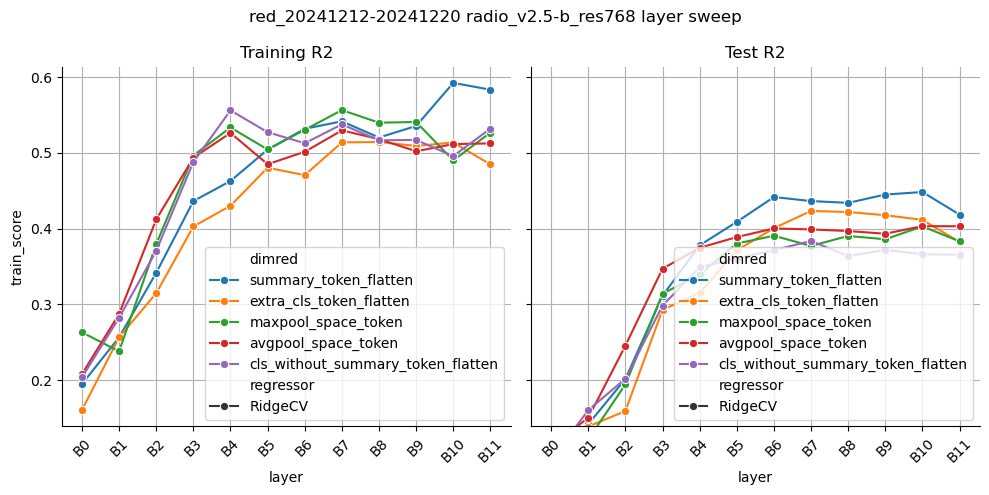

In [107]:
layer_shorten_func = lambda x: x.replace(".model.blocks.Block", "B")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

In [109]:
layer_shorten_func = lambda x: x.replace(".model.blocks.Block", "B")
result_df_formatted = format_result_df(result_df_lyrswp, dimred_list=list(Xtransforms_dict))
figh = plot_result_df_per_layer(result_df_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    result_df_masked_formatted = format_result_df(result_df_masked, dimred_list=list(Xtransforms_dict))
    figh = plot_result_df_per_layer(result_df_masked_formatted, shorten_func=layer_shorten_func, sharey=True, grid=True)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")

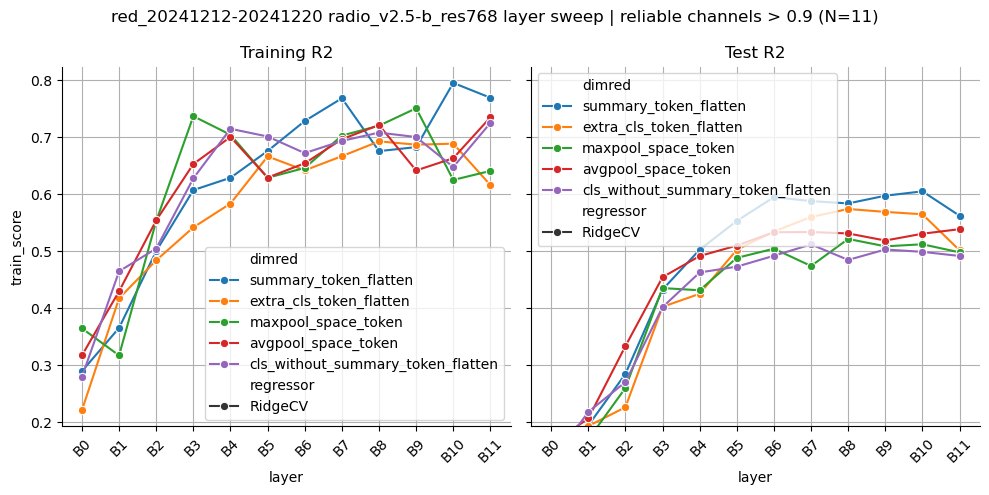

In [110]:
figh